In [3]:
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

from matplotlib import pyplot as plt
import seaborn as sns
import eli5

from tqdm import tqdm

from sklearn.model_selection import KFold
#from ml_metrics import rmsle

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

%matplotlib inline

In [4]:
df_test = pd.read_csv(r'C:\Users\Teresa\Desktop\Python_jupyter_trening\house_price\input\test.csv')
df_train = pd.read_csv(r'C:\Users\Teresa\Desktop\Python_jupyter_trening\house_price\input\train.csv')
df_subs = pd.read_csv(r'C:\Users\Teresa\Desktop\Python_jupyter_trening\house_price\input\sample_submission.csv')

df_test.shape, df_train.shape, df_subs.shape

((1459, 80), (1460, 81), (1459, 2))

In [5]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Figure size 32400x1440 with 0 Axes>

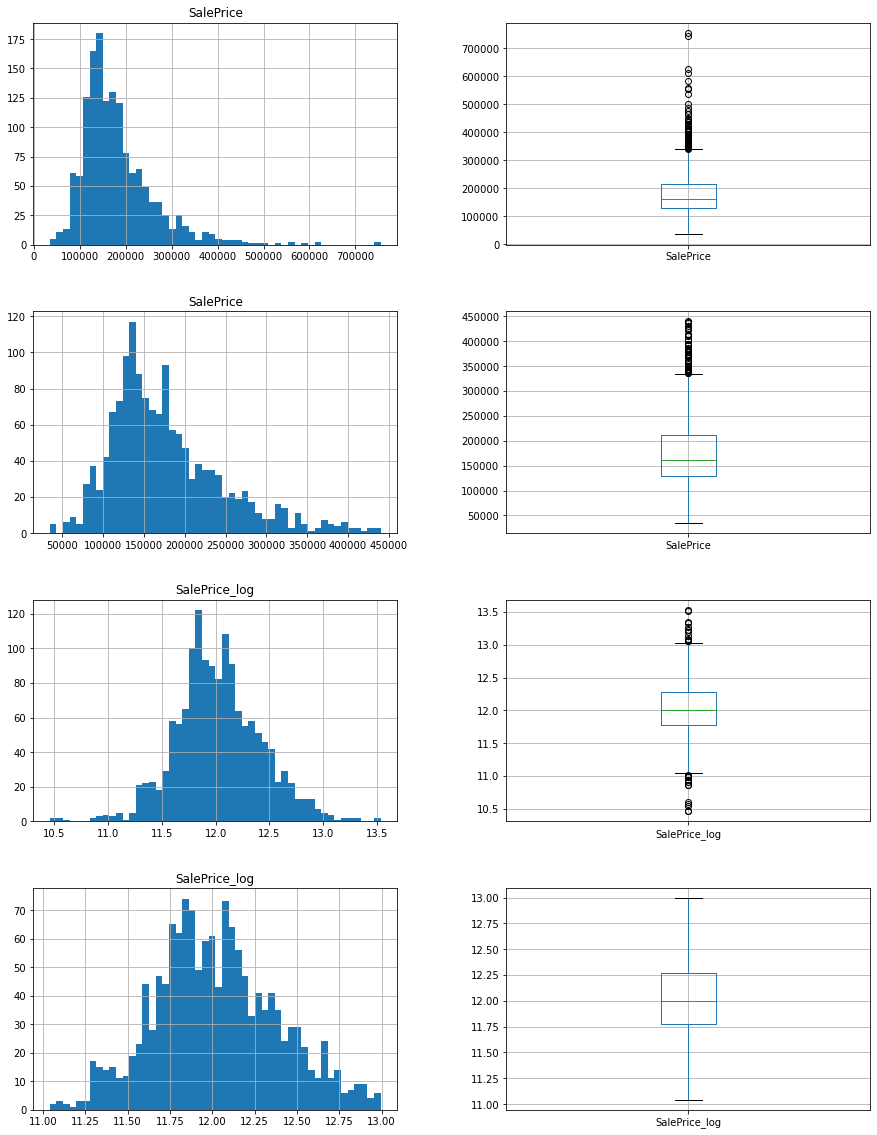

In [6]:
df_train['SalePrice_log'] = np.log( df_train['SalePrice'] )

plt.figure(figsize=(450,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 20))
fig.subplots_adjust(hspace=.8)

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=50, ax=ax1)
    data.boxplot(column, ax=ax2)

sub_plot(df_train, 'SalePrice', ax1, ax2)
sub_plot(df_train[ df_train.SalePrice < np.percentile( df_train.SalePrice, 99 ) ], 'SalePrice', ax3, ax4)
sub_plot(df_train, 'SalePrice_log', ax5, ax6)
sub_plot(df_train[ (df_train.SalePrice_log > np.percentile( df_train.SalePrice_log, 1 )) & (df_train.SalePrice_log < np.percentile( df_train.SalePrice_log, 99 )) ], 'SalePrice_log', ax7, ax8)

In [7]:
def feat_normal(x):
    perc_99 = np.percentile(x,99)
    perc_1 = np.percentile(x,1)
    if (x > perc_99): return perc_99
    elif (x < perc_1): return perc_1
    else: return x

In [8]:
df_train['SalePrice_norm'] = df_train['SalePrice'].map(feat_normal)
df_train['SalePrice_log'] = np.log( df_train['SalePrice_norm'] )
df_train['SalePrice_sqrt'] = np.sqrt( df_train['SalePrice_norm'] )

In [9]:
df = pd.concat([df_train, df_test])
df.shape

(2919, 84)

In [10]:
df_test.shape[0] + df_train.shape[0] == df.shape[0]

True

In [11]:
results=[]
def checking_missing(df):
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue
        print(missing)
        results.append(missing)

In [12]:
checking_missing(df)

('MSZoning', 4)
('LotFrontage', 486)
('Alley', 2721)
('Utilities', 2)
('Exterior1st', 1)
('Exterior2nd', 1)
('MasVnrType', 24)
('MasVnrArea', 23)
('BsmtQual', 81)
('BsmtCond', 82)
('BsmtExposure', 82)
('BsmtFinType1', 79)
('BsmtFinSF1', 1)
('BsmtFinType2', 80)
('BsmtFinSF2', 1)
('BsmtUnfSF', 1)
('TotalBsmtSF', 1)
('Electrical', 1)
('BsmtFullBath', 2)
('BsmtHalfBath', 2)
('KitchenQual', 1)
('Functional', 2)
('FireplaceQu', 1420)
('GarageType', 157)
('GarageYrBlt', 159)
('GarageFinish', 159)
('GarageCars', 1)
('GarageArea', 1)
('GarageQual', 159)
('GarageCond', 159)
('PoolQC', 2909)
('Fence', 2348)
('MiscFeature', 2814)
('SaleType', 1)
('SalePrice', 1459)
('SalePrice_log', 1459)
('SalePrice_norm', 1459)
('SalePrice_sqrt', 1459)


In [13]:
def get_my_min_max(vals, coef=1.5):
    q1 = np.percentile(vals, 25)
    q3 = np.percentile(vals, 75)
    iqr = q3 - q1

    my_min = q1 - coef*iqr
    my_max = q3 + coef*iqr
    
    print("outliers (min): ", vals[ vals < my_min ].shape[0])
    print("outliers (max): ", vals[ vals > my_max ].shape[0])

    return my_min, my_max

In [14]:
list_check = list(df.select_dtypes("number").columns)
for i in list_check:
    print("Feature:", i)
    my_min, my_max = get_my_min_max( df[i], 1.5)
    my_min, my_max

Feature: Id
outliers (min):  0
outliers (max):  0
Feature: MSSubClass
outliers (min):  0
outliers (max):  207
Feature: LotFrontage
outliers (min):  0
outliers (max):  0
Feature: LotArea
outliers (min):  1
outliers (max):  127
Feature: OverallQual
outliers (min):  4
outliers (max):  0
Feature: OverallCond
outliers (min):  67
outliers (max):  185
Feature: YearBuilt
outliers (min):  9
outliers (max):  0
Feature: YearRemodAdd
outliers (min):  0
outliers (max):  0
Feature: MasVnrArea
outliers (min):  0
outliers (max):  0
Feature: BsmtFinSF1
outliers (min):  0
outliers (max):  0
Feature: BsmtFinSF2
outliers (min):  0
outliers (max):  0
Feature: BsmtUnfSF
outliers (min):  0
outliers (max):  0
Feature: TotalBsmtSF
outliers (min):  0
outliers (max):  0
Feature: 1stFlrSF
outliers (min):  0
outliers (max):  42
Feature: 2ndFlrSF
outliers (min):  0
outliers (max):  8
Feature: LowQualFinSF
outliers (min):  0
outliers (max):  40
Feature: GrLivArea
outliers (min):  0
outliers (max):  74
Feature: BsmtF

In [15]:
for i in df.columns:
    if i in ["SalePrice_log", "SalePrice", "SalePrice_norm", "SalePrice_sqrt"]: continue
    df[i].fillna('-1',inplace=True)

In [16]:
checking_missing(df)

('SalePrice', 1459)
('SalePrice_log', 1459)
('SalePrice_norm', 1459)
('SalePrice_sqrt', 1459)


In [17]:
if "SalePrice" in df: del df['SalePrice']
if "SalePrice_norm" in df: del df['SalePrice_norm'] 
if "SalePrice_sqrt" in df: del df['SalePrice_sqrt']  
      
checking_missing(df)

('SalePrice_log', 1459)


In [18]:
cat_feats = df.select_dtypes(include =[np.object]).columns
#cat_feats
for cat_feat in cat_feats:
    df['{0}_cat'.format(cat_feat)] = pd.factorize(df[cat_feat])[0]

C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\2316571398.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_feats = df.select_dtypes(include =[np.object]).columns


In [19]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'GarageCars_cat', 'GarageArea_cat', 'GarageQual_cat', 'GarageCond_cat',
       'PavedDrive_cat', 'PoolQC_cat', 'Fence_cat', 'MiscFeature_cat',
       'SaleType_cat', 'SaleCondition_cat'],
      dtype='object', length=135)

In [20]:
def get_feats(df, black_list):
    num_feats = df.select_dtypes(np.number).columns
    return [x for x in num_feats if x not in black_list]

In [21]:
feats = get_feats(df, black_list =  [ "Id", "SalePrice_log", "SalePrice_sqrt" ])
all_cont_feats = [feat for feat in feats ]
[ (feat, df[feat].skew()) for feat in all_cont_feats ]

[('MSSubClass', 1.3761646373261713),
 ('LotArea', 12.829024853018762),
 ('OverallQual', 0.19721180528040133),
 ('OverallCond', 0.5706053117352524),
 ('YearBuilt', -0.6001139748696814),
 ('YearRemodAdd', -0.45125229728739846),
 ('1stFlrSF', 1.4703601055379227),
 ('2ndFlrSF', 0.8621178325657642),
 ('LowQualFinSF', 12.094977192517302),
 ('GrLivArea', 1.2700104075191514),
 ('FullBath', 0.16769191818882379),
 ('HalfBath', 0.6949236492716564),
 ('BedroomAbvGr', 0.32649214927079917),
 ('KitchenAbvGr', 4.304466641562935),
 ('TotRmsAbvGrd', 0.7587568676624701),
 ('Fireplaces', 0.733871770878103),
 ('WoodDeckSF', 1.8433802126628294),
 ('OpenPorchSF', 2.5364173160468444),
 ('EnclosedPorch', 4.005950070504265),
 ('3SsnPorch', 11.381914394786643),
 ('ScreenPorch', 3.948723141292199),
 ('PoolArea', 16.9070172435751),
 ('MiscVal', 21.958480324447216),
 ('MoSold', 0.19598466898916275),
 ('YrSold', 0.13246689568568673),
 ('MSZoning_cat', 2.724879912480392),
 ('LotFrontage_cat', 1.1917594386389188),
 ('

In [22]:
for feat in tqdm(all_cont_feats):
    if df[feat].skew() < 0.25: continue
    df[feat + '_sqrt'] = np.sqrt( minmax_scale(df[feat]) )
    df[feat + '_log1p'] = np.log1p( minmax_scale(df[feat]) )
    
sqrt_cont_feats = [feat for feat in df.columns if feat.endswith('sqrt') and feat != 'SalePrice_sqrt' ]
log_cont_feats = [feat for feat in df.columns if feat.endswith('log1p') ]

 10%|████▎                                      | 8/79 [00:00<00:00, 76.14it/s]C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_sqrt'] = np.sqrt( minmax_scale(df[feat]) )
C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_log1p'] = np.log1p( minmax_scale(df[feat]) )
C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented

C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_sqrt'] = np.sqrt( minmax_scale(df[feat]) )
C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_log1p'] = np.log1p( minmax_scale(df[feat]) )
 27%|███████████▏                              | 21/79 [00:14<00:39,  1.47it/s]C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented

 41%|█████████████████                         | 32/79 [00:17<00:20,  2.34it/s]C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_sqrt'] = np.sqrt( minmax_scale(df[feat]) )
C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_log1p'] = np.log1p( minmax_scale(df[feat]) )
 42%|█████████████████▌                        | 33/79 [00:17<00:18,  2.43it/s]C:\Users\Teresa\AppData\Local\Temp\ipy

 54%|██████████████████████▊                   | 43/79 [00:21<00:16,  2.21it/s]C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_sqrt'] = np.sqrt( minmax_scale(df[feat]) )
C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_log1p'] = np.log1p( minmax_scale(df[feat]) )
 56%|███████████████████████▍                  | 44/79 [00:22<00:15,  2.27it/s]C:\Users\Teresa\AppData\Local\Temp\ipy

 67%|████████████████████████████▏             | 53/79 [00:25<00:09,  2.69it/s]C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_sqrt'] = np.sqrt( minmax_scale(df[feat]) )
C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_log1p'] = np.log1p( minmax_scale(df[feat]) )
 68%|████████████████████████████▋             | 54/79 [00:26<00:09,  2.72it/s]C:\Users\Teresa\AppData\Local\Temp\ipy

C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_log1p'] = np.log1p( minmax_scale(df[feat]) )
 81%|██████████████████████████████████        | 64/79 [00:30<00:05,  2.70it/s]C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_sqrt'] = np.sqrt( minmax_scale(df[feat]) )
C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:4: PerformanceWarning: DataFrame is highly fragmented

 92%|██████████████████████████████████████▊   | 73/79 [00:33<00:02,  2.72it/s]C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_sqrt'] = np.sqrt( minmax_scale(df[feat]) )
C:\Users\Teresa\AppData\Local\Temp\ipykernel_9424\1488080189.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feat + '_log1p'] = np.log1p( minmax_scale(df[feat]) )
 94%|███████████████████████████████████████▎  | 74/79 [00:33<00:01,  2.66it/s]C:\Users\Teresa\AppData\Local\Temp\ipy

In [23]:
all_cont_feats_small = [feat for feat in feats if df[feat].skew() < 0.25 ]
print("all_cont_feats_small:\n", all_cont_feats_small)
print("sqrt_cont_feats:\n", sqrt_cont_feats)
print("log_cont_feats:\n", log_cont_feats)

all_cont_feats_small:
 ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'FullBath', 'MoSold', 'YrSold', 'Neighborhood_cat', 'BsmtFullBath_cat']
sqrt_cont_feats:
 ['MSSubClass_sqrt', 'LotArea_sqrt', 'OverallCond_sqrt', '1stFlrSF_sqrt', '2ndFlrSF_sqrt', 'LowQualFinSF_sqrt', 'GrLivArea_sqrt', 'HalfBath_sqrt', 'BedroomAbvGr_sqrt', 'KitchenAbvGr_sqrt', 'TotRmsAbvGrd_sqrt', 'Fireplaces_sqrt', 'WoodDeckSF_sqrt', 'OpenPorchSF_sqrt', 'EnclosedPorch_sqrt', '3SsnPorch_sqrt', 'ScreenPorch_sqrt', 'PoolArea_sqrt', 'MiscVal_sqrt', 'MSZoning_cat_sqrt', 'LotFrontage_cat_sqrt', 'Street_cat_sqrt', 'Alley_cat_sqrt', 'LotShape_cat_sqrt', 'LandContour_cat_sqrt', 'Utilities_cat_sqrt', 'LotConfig_cat_sqrt', 'LandSlope_cat_sqrt', 'Condition1_cat_sqrt', 'Condition2_cat_sqrt', 'BldgType_cat_sqrt', 'HouseStyle_cat_sqrt', 'RoofStyle_cat_sqrt', 'RoofMatl_cat_sqrt', 'Exterior1st_cat_sqrt', 'Exterior2nd_cat_sqrt', 'MasVnrType_cat_sqrt', 'MasVnrArea_cat_sqrt', 'ExterQual_cat_sqrt', 'ExterCond_cat_sqrt', 'Foundation_cat_sq

In [24]:
feats = all_cont_feats_small + sqrt_cont_feats + log_cont_feats
#print(feats)

In [25]:
df.SalePrice_log.isnull().shape[0]

2919

In [26]:
models = [
    ('xgb', xgb.XGBRegressor(max_depth=5, n_estimators=50, random_state=0)),
    ('ctb', ctb.CatBoostRegressor(n_estimators=100, depth=5, random_state=0, verbose=False)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=0, max_depth=3)),
]

In [27]:
df_result = pd.DataFrame()

for model_name, model in tqdm(models):
    df_train = df[ df["SalePrice_log"].notnull() ].copy()
    df_test = df[ df["SalePrice_log"].isnull() ].copy()

    X_train = df_train[feats].values
    y_train = df_train["SalePrice_log"].values
    X_test = df_test[feats].values
    
    model.fit(X_train, y_train)
    df_result[model_name] = model.predict(X_test) 

100%|████████████████████████████████████████████| 3/3 [00:06<00:00,  2.00s/it]


In [28]:
df_result["mean_log_xgb_ctb_lgb"] = df_result[ ["xgb", "ctb", "lgb"] ].mean(axis=1)
df_result

,xgb,ctb,lgb,mean_log_xgb_ctb_lgb
0,11.647489,11.714590,11.693102,11.685060
1,11.941853,11.944151,11.898538,11.928181
2,12.024013,12.158502,12.077850,12.086788
3,12.103778,12.190774,12.155236,12.149929
4,12.160376,12.096164,12.157775,12.138105
...,...,...,...,...
1454,11.319410,11.294113,11.236372,11.283298
1455,11.286346,11.339095,11.292355,11.305932
1456,11.966090,12.044907,12.031019,12.014005
1457,11.759774,11.768570,11.711093,11.746479


In [29]:
# score = 0.12595 
df_test["SalePrice"] = np.exp(df_result["mean_log_xgb_ctb_lgb"]) 

In [30]:
df_test[ ["Id", "SalePrice"] ].to_csv('C:/Users/Teresa/Desktop/Python_jupyter_trening/house_price/output/xgboost_thr_1_log_last_check_one_loop.csv', index=False) 


In [31]:
df_test["SalePrice"]

0       118783.756766
1       151475.707629
2       177511.035458
3       189080.721583
4       186858.115751
            ...      
1454     79482.991673
1455     81302.496389
1456    165050.276182
1457    126308.037701
1458    229221.929555
Name: SalePrice, Length: 1459, dtype: float64

In [32]:
eli5.show_weights(model, feature_names=feats, top=20)

Weight,Feature
0.4746,OverallQual
0.1583,GrLivArea_sqrt
0.0744,YearBuilt
0.0560,1stFlrSF_sqrt
0.0332,GarageCars_cat_sqrt
0.0271,LotArea_sqrt
0.0259,YearRemodAdd
0.0210,Fireplaces_sqrt
0.0177,CentralAir_cat_sqrt
0.0146,OverallCond_sqrt


In [33]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(15, 5))
    plt.title("Feature importances")
    plt.bar(range(df[feats].shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(df[feats].shape[1]), [ feats[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, df[feats].shape[1]])
    plt.show()

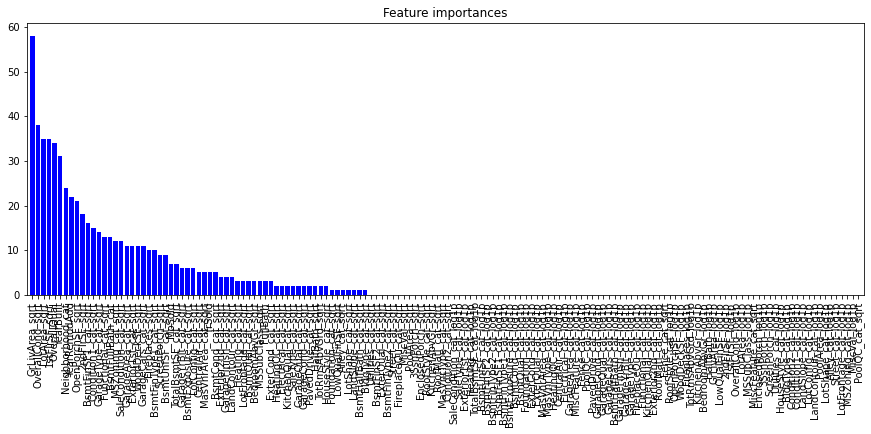

In [34]:
draw_feature_importances(model, feats)